# **R181600B - Sheunesu C Tazvivinga**
# **R181558W - Tafadzwa N Yemeke**

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
from skimage.transform import resize
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout, Bidirectional
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import SGD
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense,InputLayer
from keras.utils.vis_utils import plot_model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

In [4]:
from keras.applications.vgg16 import VGG16
# load the model
model = VGG16(weights='imagenet')

553476096/553467096 [==============================] - 4s 0us/step


In [5]:
#Load a video from file
video_input_file_path = ('/content/drive/My Drive/KBS/Object_detection/Everyday Objects In Macro.mp4')

#ORIGINAL YOUTUBE VIDEO
#https://youtu.be/K8rpo9e7tvg

#Output file
feature_output_file_path = ('/content/drive/My Drive/KBS/Object_detection/Frames/')

In [6]:
video = cv2.VideoCapture(video_input_file_path)
frameRate = video.get(5)

In [7]:
import math
count = 0
while(video.isOpened()):
    frameNum = video.get(1)
    ret, frame = video.read()
    if (ret != True):
        break
    if (frameNum % math.floor(frameRate) == 0):
        frameName = feature_output_file_path + "frame%d.jpg" % count;count+=1
        cv2.imwrite(frameName, frame)
video.release()
print ("Frame Capturing complete!")

Frame Capturing complete!


In [8]:
#Checking if the capturing returned any files
current_dir = os.getcwd()
#Access the contents in the current directory
contents = os.listdir(current_dir) 
print("Available contents in %r: %s" % (current_dir, contents))

Available contents in '/content': ['.config', 'drive', 'sample_data']


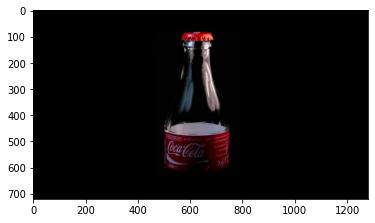

In [9]:
sample = plt.imread('/content/drive/My Drive/KBS/Object_detection/Frames/frame19.jpg')
plt.imshow(sample)

In [10]:
frames = '/content/drive/My Drive/KBS/Object_detection/Frames/*.jpg'

images = []
import glob
for filename in glob.glob(frames): 
  frame = image.load_img(filename, target_size=(224,224,224)) 
  images.append(frame)

for frame in images:
  frame_arr = image.img_to_array(frame)

In [11]:
frame_arr.shape

(224, 224, 3)

In [12]:
frame_arr = np.expand_dims(frame_arr, axis = 0)

In [13]:
# prepare the image for the VGG model
image = preprocess_input(frame_arr)

In [14]:
# predict the probability across all output classes
yhat = model.predict(image)

In [15]:
# convert the probabilities to class labels
from keras.applications.vgg16 import decode_predictions
label = decode_predictions(yhat)

49152/35363 [=========================================] - 0s 0us/step


In [16]:
# retrieve the most likely result, e.g. highest probability
label = label[0][0]

In [17]:
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

volcano (36.68%)


# Configuring streamlit

In [18]:
!pip install -q streamlit

     |████████████████████████████████| 7.8MB 5.6MB/s 
     |████████████████████████████████| 112kB 46.1MB/s 
     |████████████████████████████████| 174kB 43.3MB/s 
     |████████████████████████████████| 4.2MB 36.3MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 122kB 46.3MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.


In [19]:
!pip -q install pyngrok

     |████████████████████████████████| 747kB 7.2MB/s 


In [20]:
from pyngrok import ngrok

In [27]:
!ngrok authtoken 1npJviy2rm2H1RzUbevBUv2GLGw_ep9y73PeZMfA5zeSBzzs

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [28]:
%%writefile app.py
import streamlit as st
import tempfile
import cv2    
import math  
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from PIL import Image

PAGE_CONFIG = {"page_title":"StColab.io", "page_icon":":smiley:","layout":"centered"}
st.set_page_config("PAGE_CONFIG")

st.title("VGG16 Object Detection")
st.sidebar.title("Dashboard")
def uploadFile():
  vid_file = st.file_uploader("Upload a video", type=["mp4", "mov","avi"])
  tempVideo = tempfile.NamedTemporaryFile(delete=False) 
  if vid_file is not None: 
    tempVideo.write(vid_file.read())
  return tempVideo.name
        
def splitVideo(videoPath):
  count = 0
  cap = cv2.VideoCapture(videoPath)
  frameRate = cap.get(5) 
  tempImage = tempfile.NamedTemporaryFile(delete=False) 
  x=1

  while(cap.isOpened()):
    frameId = cap.get(1) 
    ret, frame = cap.read()
    if (ret != True):
      break
    if (frameId % math.floor(frameRate) == 0):
      tempImage = videoPath.split('.')[0] +"_frame%d.jpg" % count;count+=1
      cv2.imwrite(tempImage, frame)
      frames.append(tempImage)
  cap.release() 
  return frames,count

def classifyObjects():  
  model = VGG16()
  classify = []
  frames,count = splitVideo(videoFile)

  for i in range(count):    
    image = load_img(frames[i], target_size=(224, 224)) 
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)   
    img_pred = model.predict(image)
    label = decode_predictions(img_pred)    
    label = label[0][0]
    result =  label[1]
    classify.append(result)
  return classify

def searchInFrames(object_):
  indeces = []
  classifications = classifyObjects()
  if object_ in classifications:
    for i in range(len(classifications)):
      if classifications[i] == object_:
        index = classifications.index(object_)
        indeces.append(index)
        filePath = frames[index]
        img = load_img(filePath, target_size = (224, 224))
        detected_paths.append(filePath)
    for i in range(len(indeces)):
      st.image(frames[i], width=224)
  else:
    st.write("Object not available in video!")

videoFile = uploadFile()
user_input = st.text_input("Enter object to search: ")

if st.button('Search'):  
  frames =[]
  detected_paths = []
  searchInFrames(user_input)
  st.write("")

Overwriting app.py


In [29]:
!streamlit run --server.port 80 app.py &>/dev/null&

In [30]:
address = ngrok.connect(port=8501)

In [31]:
print(address)

NgrokTunnel: "http://4e3b27b8368d.ngrok.io" -> "http://localhost:80"


**If more processes run, kill tunnels**

In [26]:
ngrok.kill()